In [1]:
!pip install hdbscan -q
!pip install umap -q
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00


# Overview
This notebook is my submission of the General task i.e. first task for the project titled "Foundation Models for Exoplanet Characterization" by EXXA @ ML4SCI under GSoC'25

I will explore two major approaches for the unsupervised clustering

## Approach 1: Using features extracted from a pretrained Vision Transformer
A base or large ViT models is used to extract image embeddings which are used for clustering using various unsupervised clustering algorithms, I tried with various algorithms mentioned in this notebook but for clarity I am displaying the algorith which is best suited for the task 

## Approach 2: Custom clustring model using hand-crafted features
Various physics informed features are extracted from the image using methods as described in detail later in this notebook, these features are highly interpretable and provide a better insight into the images and the distinctions between them. The images are then clustered based on these features

#### NOTE: All these approaches are detailed in detail later in the notebook as and when required

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
from glob import glob
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan
from sklearn.manifold import TSNE
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import silhouette_score
from scipy import ndimage
import pickle
from skimage.feature import hog, local_binary_pattern
from skimage.measure import regionprops, moments
import torch
import torch.nn as nn
import timm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
folder_path = "/kaggle/input/gsoc-exxa/ALMA/"
print(f'Using {device}')


Using cpu


# Vision Transformer (ViT) Encoder & Clustering Pipeline

I will defines a **ViT-based feature extractor** and applies various **dimensionality reduction** and **clustering techniques** on extracted features. The goal is to **encode images**, **reduce feature dimensions**, and **cluster images** effectively.

---

### **ViT Encoder**
The `ViTEncoder` class is implemented using the **timm** library for pretrained Vision Transformer (ViT) models. The key modifications include:

- Using a **single-channel input** (grayscale images) instead of the standard 3-channel RGB input.
- Modifying the first convolutional layer to take a single-channel image by **averaging the RGB weights**.
- Extracting **feature representations** from the ViT model.

Mathematically, the new convolution layer initialization is given by:

$W'_{1, h, w} = \frac{1}{3} \sum_{c=1}^{3} W_{c, h, w}$

where:
-  \( W \) are the original weights for RGB channels.
-  \( W' \) is the new weight tensor for the single-channel input.

---

### **Image Encoding Using ViT**
The `ClusterUsingViT` class extracts **deep features** using ViT and processes them for clustering.

#### **Feature Extraction**
- Passes images through the **ViTEncoder**.
- Stores feature embeddings as a **NumPy array**.
- **Standardizes features** using `StandardScaler()`.

#### **Dimensionality Reduction**
The feature space is reduced using:

- **t-SNE** (t-Distributed Stochastic Neighbor Embedding)
- **PCA** (Principal Component Analysis)
- **UMAP** (Uniform Manifold Approximation and Projection)

---

### **Clustering Methods**
Images are clustered using:
- **Spectral Clustering**
- **K-Means Clustering**
- **HDBSCAN**
- **Hierarchical Clustering**

---

### **Usage Workflow**
1. **Extract Features**: `encode_imgs()`
2. **Reduce Dimensionality**: `reduce_dim(method='pca')`
3. **Perform Clustering**: `cluster_images(method='kmeans')`

This pipeline allows for efficient **image organization, anomaly detection, and pattern recognition** using deep learning-based features.


In [3]:
class ViTEncoder(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224.dino", in_channels=1):
        super(ViTEncoder, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        # Modify the first layer to accept single-channel input
        if (hasattr(self.model, 'patch_embed') and hasattr(self.model.patch_embed, 'proj') and in_channels==1):
            # For ViT models
            original_conv = self.model.patch_embed.proj
            
            # Create a new conv layer with single channel input but same output dimensions
            new_conv = nn.Conv2d(
                in_channels=in_channels,
                out_channels=original_conv.out_channels,
                kernel_size=original_conv.kernel_size,
                stride=original_conv.stride,
                padding=original_conv.padding,
                bias=original_conv.bias is not None
            )
            
            # Initialize the new conv layer with the average of the original weights across channels
            with torch.no_grad():
                # Average the weights across the RGB channels
                new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
                if original_conv.bias is not None:
                    new_conv.bias.data = original_conv.bias.data
                    
            # Replace the original conv layer with the new one
            self.model.patch_embed.proj = new_conv
    
    def forward(self, x):
        x = self.model(x)
        return x


class ClusterUsingViT:
    def __init__(self, data_loader, model_name = "vit_base_patch16_224.dino", in_channels=1):
        self.model = ViTEncoder(model_name, in_channels)
        self.data_loader = data_loader
        self.image_feats = []
        self.reduced_feats = None
        self.cluster_labels = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def encode_imgs(self):
        self.model.to(self.device).eval()
        for i, data in enumerate(tqdm(self.data_loader,
                                      total = len(self.data_loader))):
            images = data['img_data'].to(self.device)
            with torch.no_grad():
                out = self.model(images)
                self.image_feats.append(out.to('cpu'))
                
        self.image_feats = torch.cat(self.image_feats, dim=0).numpy()
        scaler = StandardScaler()
        self.image_feats = scaler.fit_transform(self.image_feats)
        return self.image_feats

    def reduce_dim(self, method='tsne', n_components=2, random_state=42):
        if (len(self.image_feats) == 0):
            print("Run encode_imgs() first!!")
            return 
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)

        return self.reduced_feats

    
    def cluster_images(self, method='spectral', n_clusters=3, random_state=42):
        if (method=='spectral'):
            clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', 
                                           affinity='nearest_neighbors', 
                                           random_state=random_state)
        if (method=='kmeans'):
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        if (method=='hdbscan'):
            clusterer = hdbscan.HDBSCAN(min_cluster_size=n_clusters, gen_min_span_tree=True)
        if (method == 'hierarchical'):
            clusterer = AgglomerativeClustering(n_clusters=n_clusters)
            
        self.cluster_labels = clusterer.fit_predict(self.image_feats)

        return self.cluster_labels
        


# Custom Clustering Model

This model extracts hand craftes features from the ALMA continuum data and clusters them using various techniques. The features are extracted in a way which avoides clustering based on just viewing angle.

---

## **Feature Extraction**
1. **Basic Statistical Features**: Mean, standard deviation, median, interquartile range (IQR), maximum intensity, total flux, and center of mass.
2. **Radial Features**: Mass, density, and anisotropy at different radii from the center.
3. **Elliptic Features**: Mass, density, and anisotropy computed using elliptical regions of varying sizes.
4. **Radial Profiles at Angles**: Intensity profiles sampled at 0°, 45°, 90°, and 135°.
5. **Ring Features**: Intensity statistics along circular rings.
6. **Azimuthal Symmetry**: Measures asymmetry and variance within azimuthal segments.
7. **Image Moments**: Hu moments and region properties (area, eccentricity, axis lengths, etc.).
8. **Power Spectrum Analysis**: Radial distribution of frequency components from the 2D Fourier transform.


## **Dimensionality Reduction**
- **Techniques**: t-SNE, PCA, and UMAP.
- Reduces feature space for visualization and clustering.

## **Clustering Methods**
- **K-Means**: Classical centroid-based clustering.
- **Spectral Clustering**: Uses nearest-neighbor graphs.
- **HDBSCAN**: Density-based clustering.
- **Hierarchical Clustering**: Agglomerative method for tree-based grouping.

## **Usage**
1. **Feature Extraction**: `extract_feats()`
2. **Dimensionality Reduction**: `reduce_dim(method='pca' | 'tsne' | 'umap')`
3. **Clustering**: `cluster_images(method='kmeans' | 'spectral' | 'hdbscan' | 'hierarchical')`

This model enables **unsupervised clustering** of grayscale images using **multi-scale feature representations**.


In [4]:
class CustomClusteringModel:
    def __init__(self, img_paths, transform, apply_clipping=True):
        self.img_paths = img_paths
        self.apply_clipping = apply_clipping
        self.transform = transform
        self.image_feats = None
        self.reduced_feats = None
        self.cluster_labels = None

    #defining some helper functions

    def circle_perimeter(self, cy, cx, radius, shape):
        # Create a meshgrid of coordinates
        y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
        
        # Calculate distance from center
        dist = np.sqrt(x*x + y*y)
        
        # Find indices close to the desired radius
        mask = np.abs(dist - radius) < 0.5
        
        # Get coordinates
        cy_indices, cx_indices = np.where(mask)
        
        # Adjust to center position and ensure within bounds
        cy_indices = np.clip(cy_indices + cy - radius, 0, shape[0]-1)
        cx_indices = np.clip(cx_indices + cx - radius, 0, shape[1]-1)
        
        return cy_indices, cx_indices
    
    def calculate_moments(self, image):
        image = image.squeeze().detach().cpu().numpy()
        # Calculate Hu moments
        props = regionprops(np.uint8(image > np.mean(image)))[0]
        
        # Get moment features
        moments_features = [
            props.area,
            props.eccentricity,
            props.major_axis_length,
            props.minor_axis_length,
            props.orientation,
            props.perimeter,
            props.solidity
        ]
        
        return moments_features
    
    def calculate_power_spectrum(self, image):
        # Compute 2D FFT
        image = image.squeeze().detach().cpu().numpy()
        image_fft = np.fft.fftshift(np.fft.fft2(image))
        power_spectrum = np.abs(image_fft)**2
        
        # Get center coordinates
        center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
        
        # Create radial bins
        max_radius = min(center_y, center_x) - 1
        num_bins = 20
        bin_edges = np.linspace(0, max_radius, num_bins + 1)
        
        # Calculate radial profile
        radial_profile = []
        for i in range(num_bins):
            r_min, r_max = bin_edges[i], bin_edges[i+1]
            
            # Create a mask for this radial bin
            y, x = np.ogrid[-center_y:image.shape[0]-center_y, -center_x:image.shape[1]-center_x]
            r = np.sqrt(x*x + y*y)
            mask = (r >= r_min) & (r < r_max)
            
            # Calculate mean power in this bin
            if np.sum(mask) > 0:
                radial_profile.append(np.mean(power_spectrum[mask]))
            else:
                radial_profile.append(0)
        
        return radial_profile

    def get_img(self, idx):
        img_data = fits.getdata(self.img_paths[idx])[0]
        img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        img_data = self.transform(image=img_data)
        return img_data['image']

    # define functions for feature extractions
    
    def basic_feats(self, image):
        image = image.squeeze().detach().cpu().numpy()
        feature_vector = []
        feature_vector.extend([
                np.mean(image),  # Mean intensity
                np.std(image),   # Standard deviation
                np.median(image), # Median
                np.percentile(image, 75) - np.percentile(image, 25),  # IQR
                np.max(image),   # Max intensity
                np.sum(image),   # Total flux
                ndimage.measurements.center_of_mass(image)[0],  # Center of mass Y
                ndimage.measurements.center_of_mass(image)[1],  # Center of mass X
            ])
        return feature_vector
            
    def get_radial_feats(self, image, dr=2):  # img_shape -> (1, 224, 224)
        img_np = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        h, w = img_np.shape
        y_indices, x_indices = np.indices((h, w))
        r_array = np.sqrt((x_indices - cx)**2 + (y_indices - cy)**2)
        theta_array = np.arctan2(y_indices - cy, x_indices - cx)
        r_max = 112  # max radius (half the image size)
        r_values = np.arange(0, r_max, dr)
        radial_mass = []
        radial_density = []
        radial_grad = []
        
        for r in r_values:
            # Create annulus mask
            annulus_mask = (r_array >= r) & (r_array < r + dr)
            mass = img_np[annulus_mask].sum()
            radial_mass.append(mass)
            
            # Compute annulus area
            annulus_area = np.pi * ((r + dr)**2 - r**2)
            density = mass / annulus_area if annulus_area > 0 else 0
            radial_density.append(density)
            
            # Compute mass gradient (anisotropy) along the annulus
            # Use the pixel angles within the annulus.
            annulus_masses = img_np[annulus_mask]
            annulus_angles = theta_array[annulus_mask]
            if mass > 0:
                X = np.sum(annulus_masses * np.cos(annulus_angles))
                Y = np.sum(annulus_masses * np.sin(annulus_angles))
                grad = np.sqrt(X**2 + Y**2) / mass
            else:
                grad = 0
            radial_grad.append(grad)
        
        # Normalize radial features (if desired)
        radial_mass = np.array(radial_mass)
        radial_mass_norm = (radial_mass - radial_mass.min()) / (radial_mass.max() - radial_mass.min() + 1e-8)
        
        radial_density = np.array(radial_density)
        radial_density_norm = (radial_density - radial_density.min()) / (radial_density.max() - radial_density.min() + 1e-8)
        
        radial_grad = np.array(radial_grad)
        radial_grad_norm = (radial_grad - radial_grad.min()) / (radial_grad.max() - radial_grad.min() + 1e-8)

        radial_feats = np.concatenate([radial_mass_norm,
                                       radial_density_norm,
                                       radial_grad_norm])
        return radial_feats
        
    def get_elliptic_feats(self, image): # img_shape -> (1, 224, 224)
        img_np = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        h, w = img_np.shape
        y_indices, x_indices = np.indices((h, w))
        a_values = np.linspace(1, 100, 10)
        b_values = np.linspace(1, 100, 10)
        
        elliptical_mass = []
        elliptical_density = []
        elliptical_grad = []
        for a in a_values:
            for b in b_values:
                # Elliptical mask: standard ellipse equation centered at (cx,cy)
                ellipse_mask = (((x_indices - cx)**2) / (a**2) + ((y_indices - cy)**2) / (b**2)) <= 1
                mass = img_np[ellipse_mask].sum()
                elliptical_mass.append(mass)
                
                # Ellipse area = π * a * b
                ellipse_area = np.pi * a * b
                density = mass / ellipse_area if ellipse_area > 0 else 0
                elliptical_density.append(density)
                
                # Compute elliptical gradient.
                # For the elliptical region, first normalize coordinates so the ellipse becomes a unit circle.
                # Then compute the angular distribution.
                if mass > 0:
                    x_norm = (x_indices[ellipse_mask] - cx) / a
                    y_norm = (y_indices[ellipse_mask] - cy) / b
                    angles = np.arctan2(y_norm, x_norm)
                    masses = img_np[ellipse_mask]
                    X = np.sum(masses * np.cos(angles))
                    Y = np.sum(masses * np.sin(angles))
                    grad = np.sqrt(X**2 + Y**2) / mass
                else:
                    grad = 0
                elliptical_grad.append(grad)
        
        # Convert to arrays and normalize elliptical features
        elliptical_mass = np.array(elliptical_mass)
        elliptical_mass_norm = (elliptical_mass - elliptical_mass.min()) / (elliptical_mass.max() - elliptical_mass.min() + 1e-8)
        
        elliptical_density = np.array(elliptical_density)
        elliptical_density_norm = (elliptical_density - elliptical_density.min()) / (elliptical_density.max() - elliptical_density.min() + 1e-8)
        
        elliptical_grad = np.array(elliptical_grad)
        elliptical_grad_norm = (elliptical_grad - elliptical_grad.min()) / (elliptical_grad.max() - elliptical_grad.min() + 1e-8)

        elliptic_feats = np.concatenate([
            elliptical_mass_norm,
            elliptical_density_norm,
            elliptical_grad_norm
        ])
        return elliptic_feats

    def get_radial_profiles_at_angles(self, image):
        feature_vector = []
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        for angle in [0, 45, 90, 135]:
            angle_rad = np.deg2rad(angle)
            profile = []
            for r in range(0, 112, 10):  # Sample every 10 pixels up to 300 pixels from center
                y = int(cy + r * np.sin(angle_rad))
                x = int(cx + r * np.cos(angle_rad))
                
                # Check bounds
                if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
                    profile.append(image[y, x])
                else:
                    profile.append(0)
            
            # Add profile statistics to feature vector
            feature_vector.extend([
                np.mean(profile),
                np.std(profile),
                np.max(profile),
                np.sum(profile)
            ])
        return feature_vector

    def ring_features(self, image):
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        feature_vector = []
        rings = []
        for r in range(20, 112, 10):  # Sample rings at different radii
            y_indices, x_indices = self.circle_perimeter(cy, cx, r, shape=image.shape)
            ring_values = image[y_indices, x_indices]
            
            rings.append(np.mean(ring_values))
            rings.append(np.std(ring_values))
            
        # Add ring features
        feature_vector.extend(rings)
        return feature_vector

    def azimuthal_symmetry_feats(self, image):
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        azimuthal_features = []
        for r in range(5, 112, 10):  # Check a few key radii
            # Get coordinates of points on the circle
            y_indices, x_indices = self.circle_perimeter(cy, cx, r, shape=image.shape)
            ring_values = image[y_indices, x_indices]
            
            # Measure asymmetry (ratio of max/min)
            if np.min(ring_values) > 0:
                asymmetry = np.max(ring_values) / np.min(ring_values)
            else:
                asymmetry = 1.0
                
            azimuthal_features.append(asymmetry)
            
            # Also check for specific asymmetries (potential planet signatures)
            # Divide the ring into 8 segments and look at variance
            segments = np.array_split(ring_values, 8)
            segment_means = [np.mean(seg) for seg in segments]
            azimuthal_features.append(np.var(segment_means))
        return azimuthal_features

    def extract_feats(self):
        self.image_feats = []
        for i in range(len(self.img_paths)):
            feature_vector = []
            image = self.get_img(i);
            feature_vector.extend(self.basic_feats(image))
            feature_vector.extend(self.get_radial_feats(image))
            feature_vector.extend(self.get_elliptic_feats(image))
            feature_vector.extend(self.get_radial_profiles_at_angles(image))
            feature_vector.extend(self.ring_features(image))
            feature_vector.extend(self.azimuthal_symmetry_feats(image))
            feature_vector.extend(self.calculate_moments(image))
            feature_vector.extend(self.calculate_power_spectrum(image))

            self.image_feats.append(feature_vector)

            if ((i+1)%10 == 0):
                print(f"Extracted features for {i+1} image..")
        self.image_feats = np.array(self.image_feats)
        scaler = StandardScaler()
        self.image_feats = scaler.fit_transform(self.image_feats)
        return self.image_feats
        
    def reduce_dim(self, method='tsne', n_components=2, random_state=42):
        if (self.image_feats is None):
            print("Run extract_feats() first!!")
            return 
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.image_feats)

        return self.reduced_feats

    def cluster_images(self, method='kmeans', n_clusters=3, random_state=42):
        if (self.image_feats is None):
            print("Run extract_feats() first!!")
            return 
        if (method=='spectral'):
            clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', 
                                           affinity='nearest_neighbors', 
                                           random_state=random_state)
        if (method=='kmeans'):
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        if (method=='hdbscan'):
            clusterer = hdbscan.HDBSCAN(min_cluster_size=n_clusters, gen_min_span_tree=True)
        if (method == 'hierarchical'):
            clusterer = AgglomerativeClustering(n_clusters=n_clusters)
            
        self.cluster_labels = clusterer.fit_predict(self.image_feats)

        return self.cluster_labels
        

# **Image Augmentation and Dataset Class**

I will do image preprocessing and dataset handling for. The implementation consists of two key components: **Albumentations-based transformations** and a **custom PyTorch dataset class**.

---

### **1. Image Transformations (ViT-Compatible)**
The `transform_vit` pipeline uses the **Albumentations** library for preprocessing images into a format suitable for ViTs. The key steps include:

- **Normalization:**  
  
  $I' = \frac{I - \mu}{\sigma}$

  
  where mean \($\mu$ = 0\) and standard deviation \($\sigma$ = 1\) after transformation.
  
- **Resizing & Padding:**  
  - Scales images to a max size of 256 pixels.
  - Pads smaller images to \(256 $\times$ 256\) using a constant black border.
  - Resizes all images to \(224 $\times$ 224\) for uniformity.
  
- **Conversion to Tensor:**  
  - Ensures compatibility with PyTorch models.
 
### **2. Image Transformations (For feature extractions)**
the `transform_for_feature_extraction` pipeline is same above pipeline except for the normalizations, since extracting features before normalization provides better insights. We will scale the extracted features using `StandardScaler()` in the model class

---

### **3. FITSDataset Class**
The `FITSDataset` class is a PyTorch `Dataset` that:
- Loads **FITS images** using `astropy.fits`.
- Applies **clipping** to remove extreme values (1st–99th percentile). Mathematically described as:
   $ I_{\text{clipped}} = \min(\max(I, P_1), P_{99}) $
- Supports **optional augmentations** and **channel expansion** (e.g., for CNNs expecting RGB).

Each sample returns:

$\text{{img\_data}} \in \mathbb{R}^{1 \times 224 \times 224} \text{ (or } 3 \times 224 \times 224 \text{ if expanded)}$


This setup ensures efficient loading and preprocessing of grayscale astronomical images for deep learning models.


In [5]:
transform_vit = A.Compose(
    [
        A.Normalize(
            mean=0, 
            std=1, 
            max_pixel_value=1.0,  # Adjust based on your image values
            always_apply=True,
        ),
        A.LongestMaxSize(max_size=256, always_apply=True),
        A.PadIfNeeded(
            min_height=256, 
            min_width=256, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            always_apply=True
        ),
        A.Resize(
            height=224,
            width=224,
            always_apply=True
        ),
        ToTensorV2(always_apply=True),
    ]
)

transform_for_feature_extraction = A.Compose(
    [
        A.LongestMaxSize(max_size=256, always_apply=True),
        A.PadIfNeeded(
            min_height=256, 
            min_width=256, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            always_apply=True
        ),

        A.Resize(
            height=224,
            width=224,
            always_apply=True
        ),
        ToTensorV2(always_apply=True),
    ]
)

class FITSDataset(Dataset):
    def __init__(self, fits_paths, transform = None, apply_clipping=True,
                expand_channels=False):
        self.paths = fits_paths
        self.transform = transform
        self.apply_clipping = apply_clipping
        self.expand_channels=expand_channels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_data = fits.getdata(self.paths[idx])[0]
        img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        
        if self.transform is not None:
            img_data = self.transform(image=img_data)
            if (self.expand_channels):
                img_data['image'] = img_data['image'].repeat(3, 1, 1)
                
            return {
                'img_data': img_data['image']
            }
        else:
            return {
                'img_data': img_data
            }

# Initialising Assets
Defining hyperparameters and initializing `fits_dataset`, `fits_dataloader` and clustering models i.e. `ClusterUsingViT` and `CustomClusteringModel`

#### Hyperparameters:
1. channels of images (not expanded) = $1$
2. number of clusters = $5$
3. batch size = $32$
4. `expand_channels = False` since ViT is initialized for single channel input

In [6]:
in_channels_for_vit = 1
expand_channels = False if in_channels_for_vit==1 else True
n_clusters = 5

image_paths = sorted(glob(os.path.join(folder_path, "*.fits")))
fits_dataset = FITSDataset(image_paths, transform_vit, 
                           apply_clipping=True, expand_channels=expand_channels)
fits_loader = DataLoader(fits_dataset, batch_size = batch_size, shuffle=False)

vit_cluster_obj = ClusterUsingViT(fits_loader, in_channels = in_channels_for_vit)
custom_cluster_obj = CustomClusteringModel(image_paths, transform_for_feature_extraction)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

# Get feature representations

Running encoding functions of each model to extract image features from both the models and getting dimensionally reduced features since they provide better visualization while plotting clusters

In [7]:
vit_feats = vit_cluster_obj.encode_imgs()
custom_feats = custom_cluster_obj.extract_feats()

  0%|          | 0/5 [00:00<?, ?it/s]

Extracted features for 10 image..
Extracted features for 20 image..
Extracted features for 30 image..
Extracted features for 40 image..
Extracted features for 50 image..
Extracted features for 60 image..
Extracted features for 70 image..
Extracted features for 80 image..
Extracted features for 90 image..
Extracted features for 100 image..
Extracted features for 110 image..
Extracted features for 120 image..
Extracted features for 130 image..
Extracted features for 140 image..
Extracted features for 150 image..


In [8]:
vit_reduced_feats = vit_cluster_obj.reduce_dim(method='umap')
custom_reduced_feats = custom_cluster_obj.reduce_dim(method='umap')

# Generate Cluster Labels
For generating cluster labels, I will use `SpectralClustering` which is a modification of `KMeans` clustering algorithm

---

## **Workflow of Spectral Clustering algorithm**
Spectral clustering is a graph-based clustering algorithm that leverages the eigenvalues of a similarity matrix to perform clustering. It is particularly effective for non-linearly separable data.

### **Steps**
1. **Construct Similarity Graph**  
   - Represent data as a graph where nodes are points and edges represent similarity.
   - The similarity matrix \( S \) is typically computed using a Gaussian kernel:
     
     $S_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$
   
2. **Compute Graph Laplacian**  
   - Degree matrix \( D \): Diagonal matrix where \( $D_{ii} = \sum_j S_{ij} $\).
   - Unnormalized Laplacian:  
    
     $L = D - S$

   - Normalized Laplacian:
     
     $L_{\text{sym}} = D^{-1/2} L D^{-1/2}$


3. **Compute Eigenvectors**  
   - Find the first \( k \) eigenvectors of \( $L_{\text{sym}}$ \).
   - Form a matrix \( $U \in \mathbb{R}^{n \times k}$ \) using these eigenvectors.

4. **Apply k-Means on Eigenvectors**  
   - Normalize rows of \( U \) and apply k-means clustering.

In [9]:
vit_cluster_obj.image_feats = vit_feats
vit_cluster_labels = vit_cluster_obj.cluster_images(method = 'spectral', n_clusters=n_clusters)

In [10]:
custom_cluster_obj.image_feats = custom_feats
custom_cluster_labels = custom_cluster_obj.cluster_images(method='kmeans', n_clusters=n_clusters)

# Visualizing Clusters

Defining various usefull functions for visualization of the clusters

In [11]:
class ClusterAnalyzer:
    def __init__(self, cluster_labels, img_paths, reduced_feats, transform, 
                 clustering_method, apply_clipping=True):
        self.cluster_labels = cluster_labels
        self.reduced_feats = reduced_feats
        self.img_paths = img_paths
        self.transform = transform
        self.apply_clipping = apply_clipping
        self.clustering_method = clustering_method
        self.n_clusters = len(np.unique(cluster_labels))

    def get_img(self, idx):
        img_data = fits.getdata(self.img_paths[idx])[0]
        img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        img_data = self.transform(image=img_data)
        return img_data['image'].squeeze().detach().cpu().numpy()

    def visualize_clusters(self, figsize=(12, 10)):
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            self.reduced_feats[:, 0], 
            self.reduced_feats[:, 1], 
            c=self.cluster_labels, 
            cmap='viridis', 
            alpha=0.8,
            s=50
        )
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Disk Clusters using {self.clustering_method.capitalize()} (n={self.n_clusters})')
        plt.xlabel('Reduced Dimension 1')
        plt.ylabel('Reduced Dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_cluster(self, samples_per_cluster=10):
        unique_clusters = np.unique(self.cluster_labels)
        for cluster in unique_clusters:
            if (cluster==-1):
                cluster_name = "Noise"
            else:
                cluster_name = f'Cluster {cluster}'
            cluster_indices = np.where(self.cluster_labels == cluster)[0]

            if len(cluster_indices) > 0:
                sample_indices = np.random.choice(
                    cluster_indices, 
                    size=min(samples_per_cluster, len(cluster_indices)), 
                    replace=False
                )
                n = len(sample_indices)
                cols = min(n, 3)
                rows = (n + cols - 1) // cols
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
                fig.suptitle(f"{cluster_name} - {len(cluster_indices)} samples", fontsize=16, fontweight = 'bold')
                axes = np.array(axes).reshape(-1)
                for i, idx in enumerate(sample_indices):
                    img = self.get_img(idx)
                    file_name = self.img_paths[idx].split('/')[-1]
                    axes[i].imshow(img)  
                    axes[i].axis("off")  
                    axes[i].set_title(f"File: {file_name}")
        
                for j in range(i + 1, len(axes)):
                    axes[j].axis("off")

                plt.tight_layout()
                plt.show()
            

In [12]:
vit_cluster_analyzer = ClusterAnalyzer(vit_cluster_labels, image_paths, 
                                      vit_reduced_feats, transform_vit, 
                                      'Spectral')
custom_cluster_analyser = ClusterAnalyzer(custom_cluster_labels, image_paths,
                                         custom_reduced_feats, transform_for_feature_extraction,
                                         'kmeans')

# Visualizing ViT + Spectral Clustering

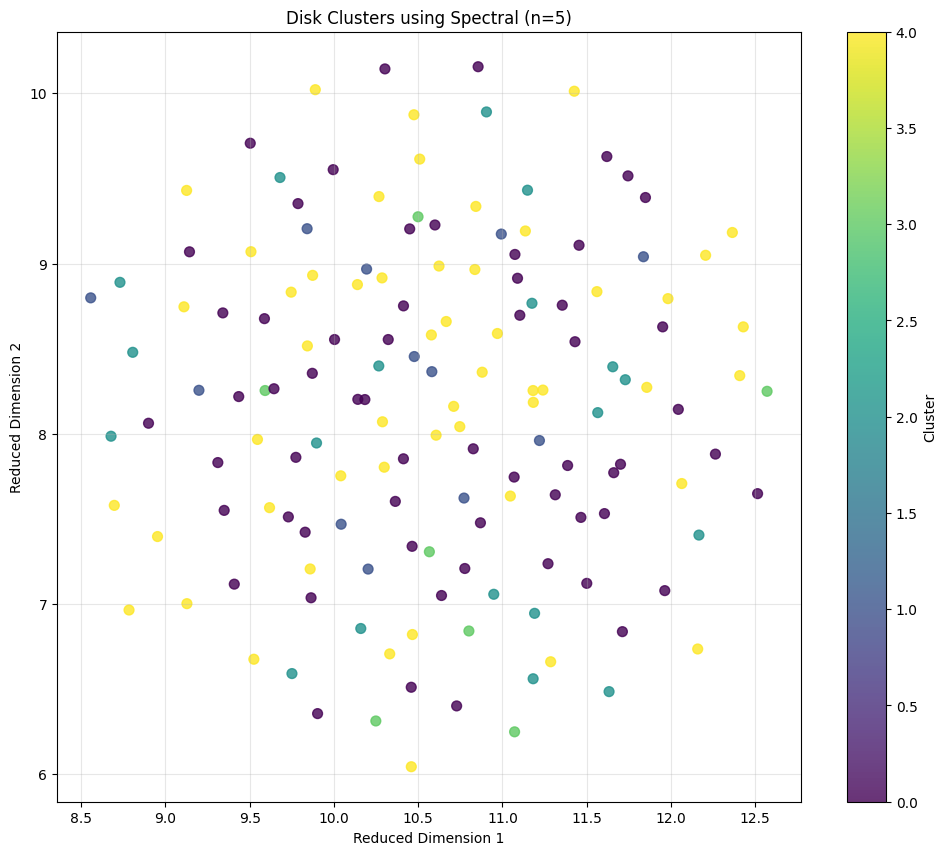

In [13]:
vit_cluster_analyzer.visualize_clusters()

## Cluster Samples

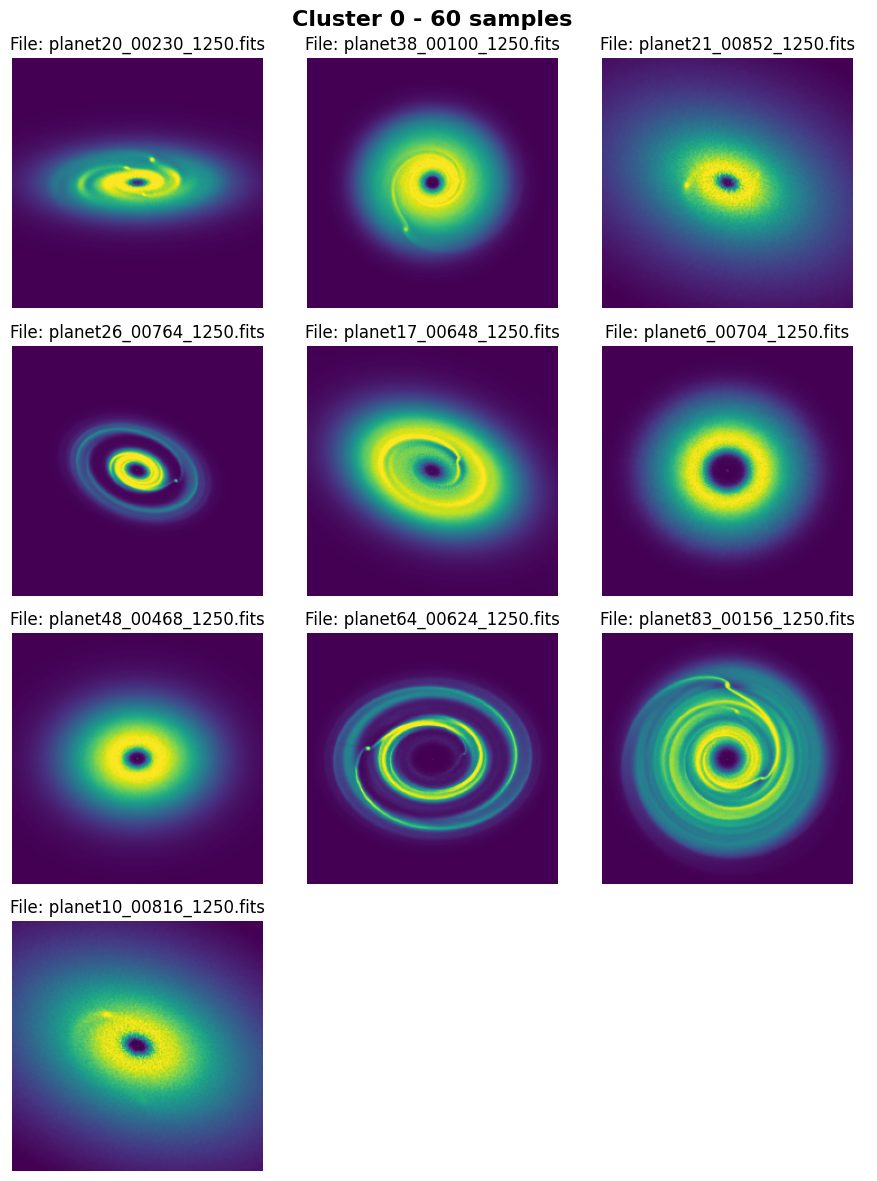

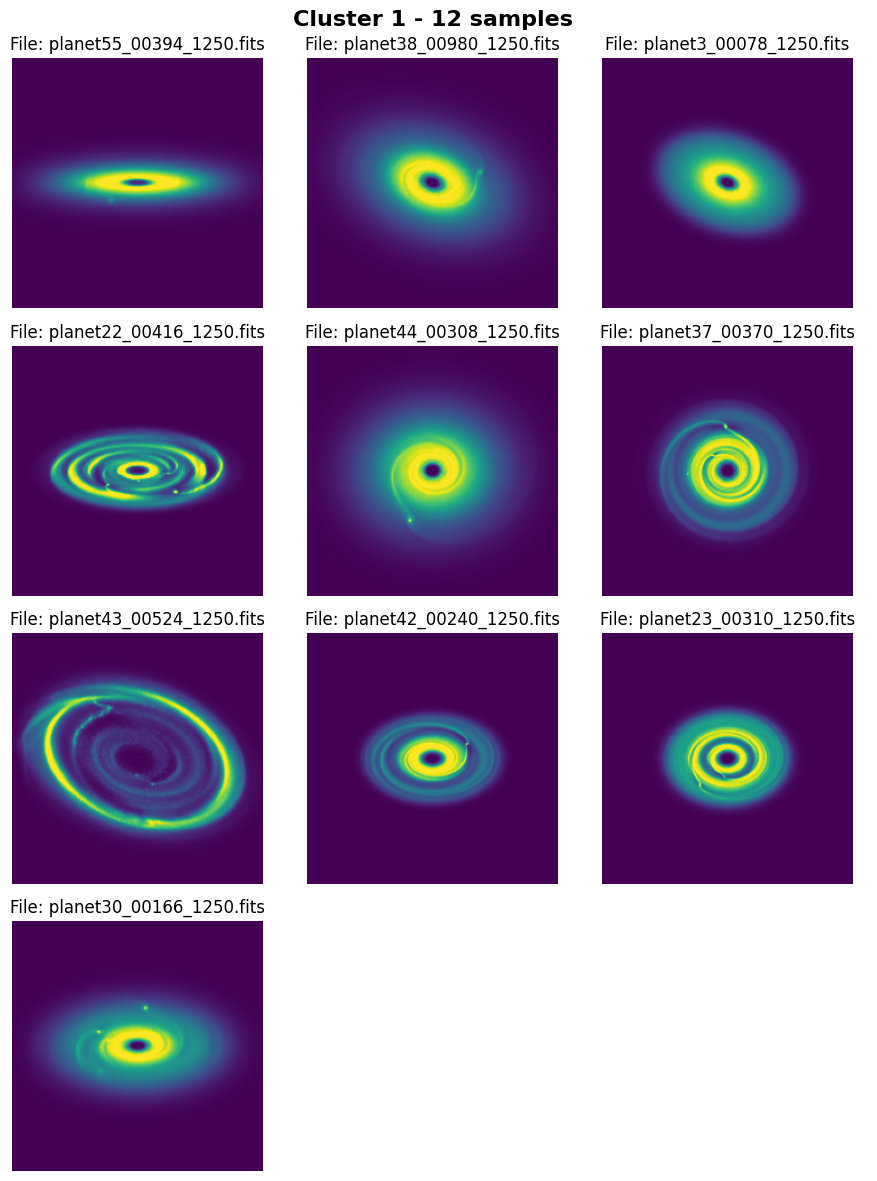

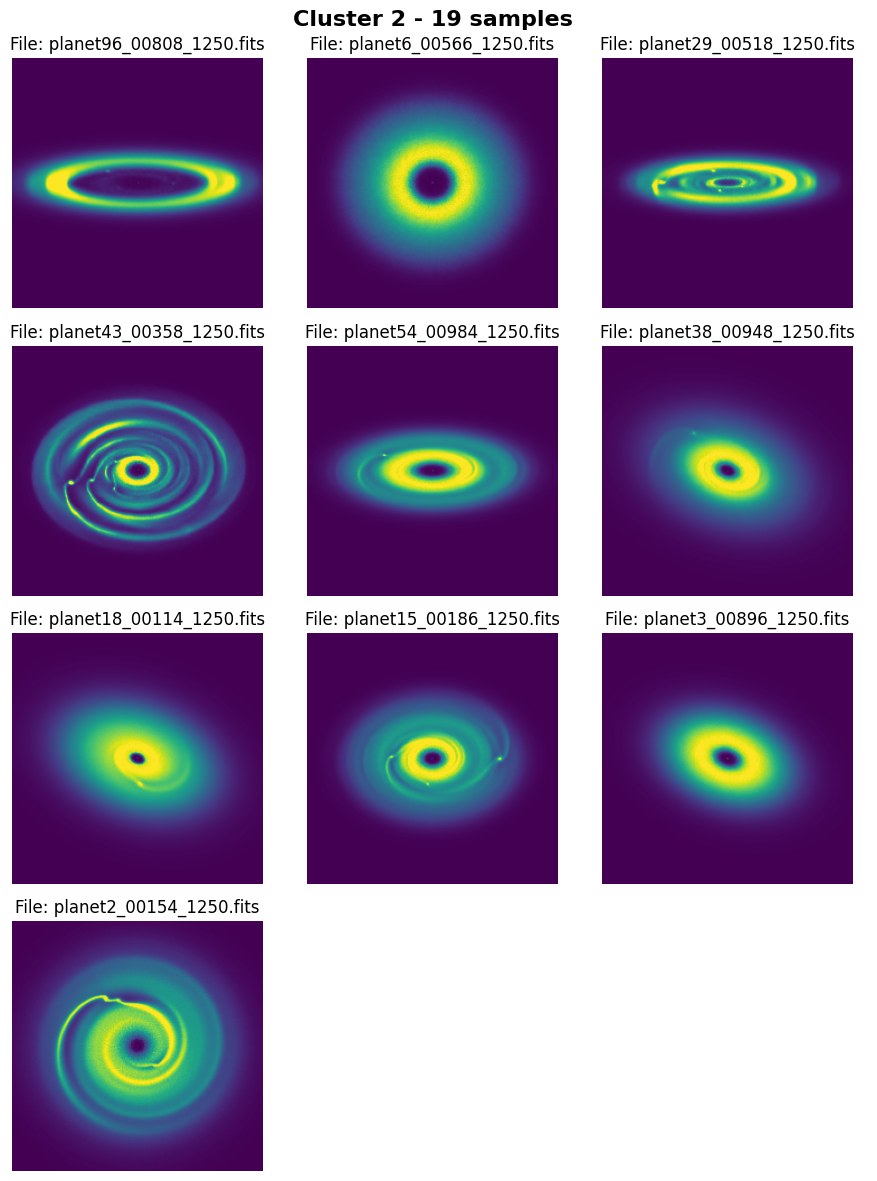

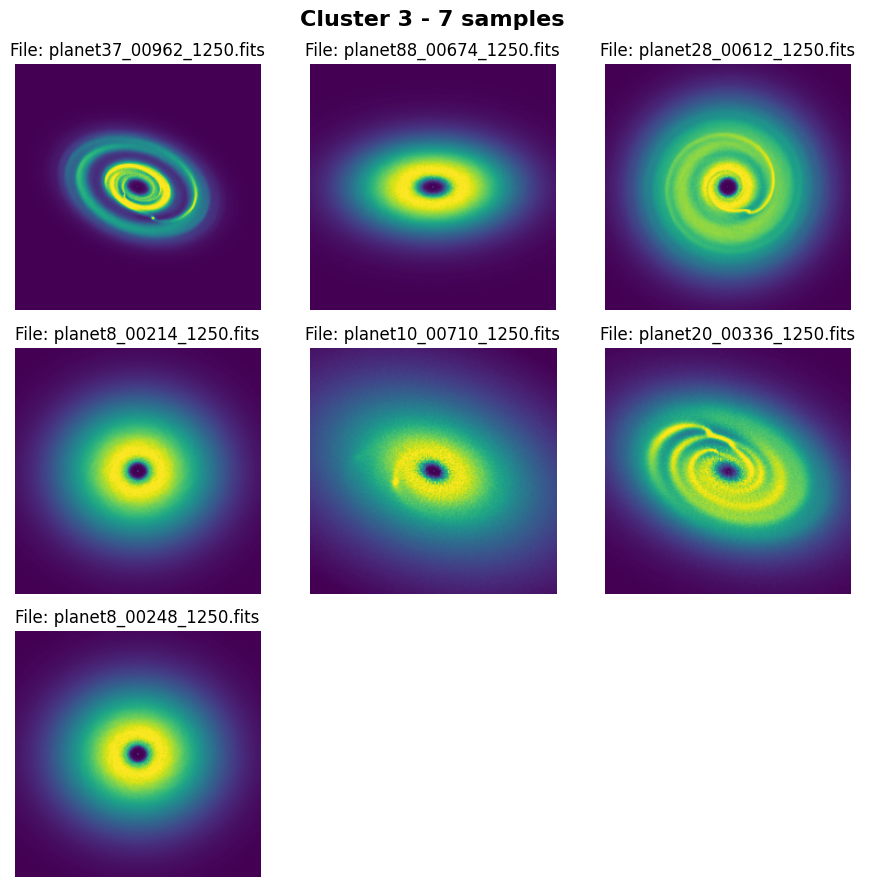

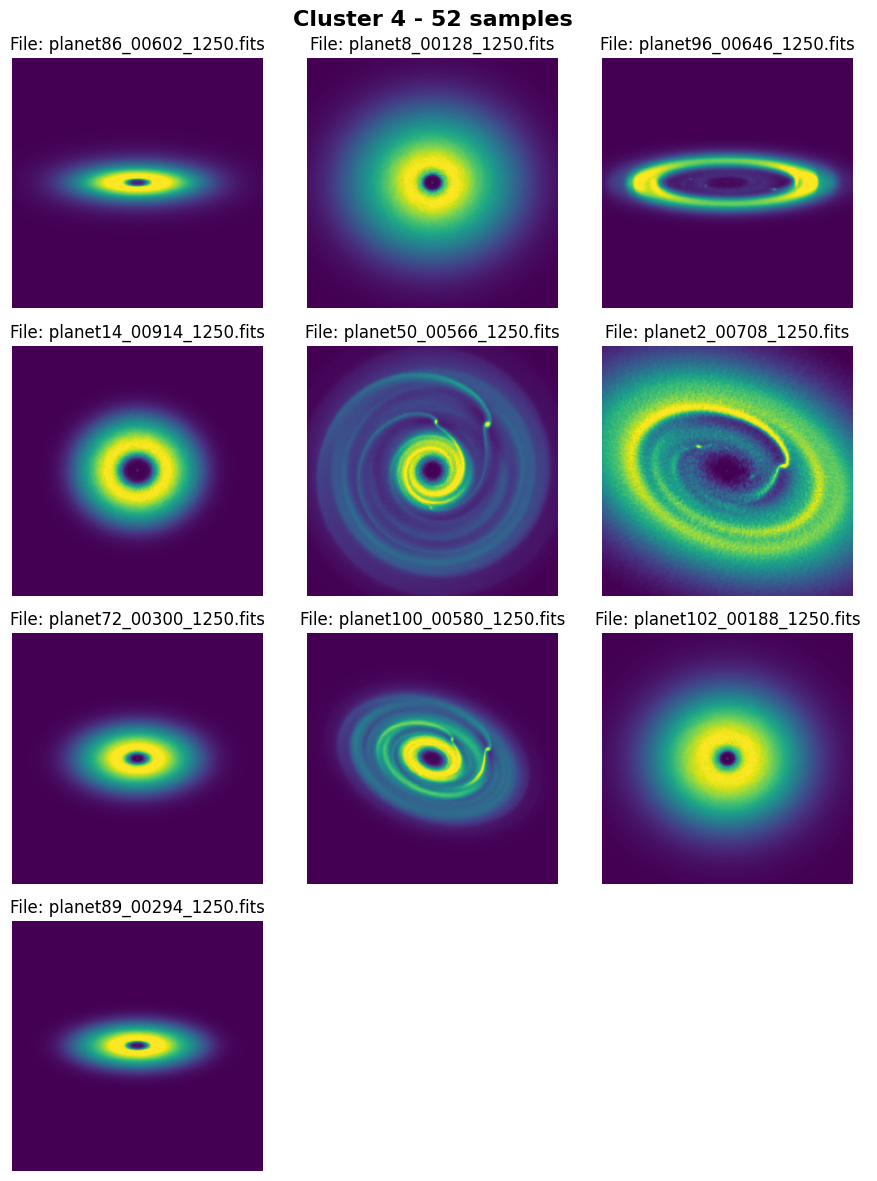

In [14]:
vit_cluster_analyzer.plot_cluster()

# Visualizing Custom Clustering Model

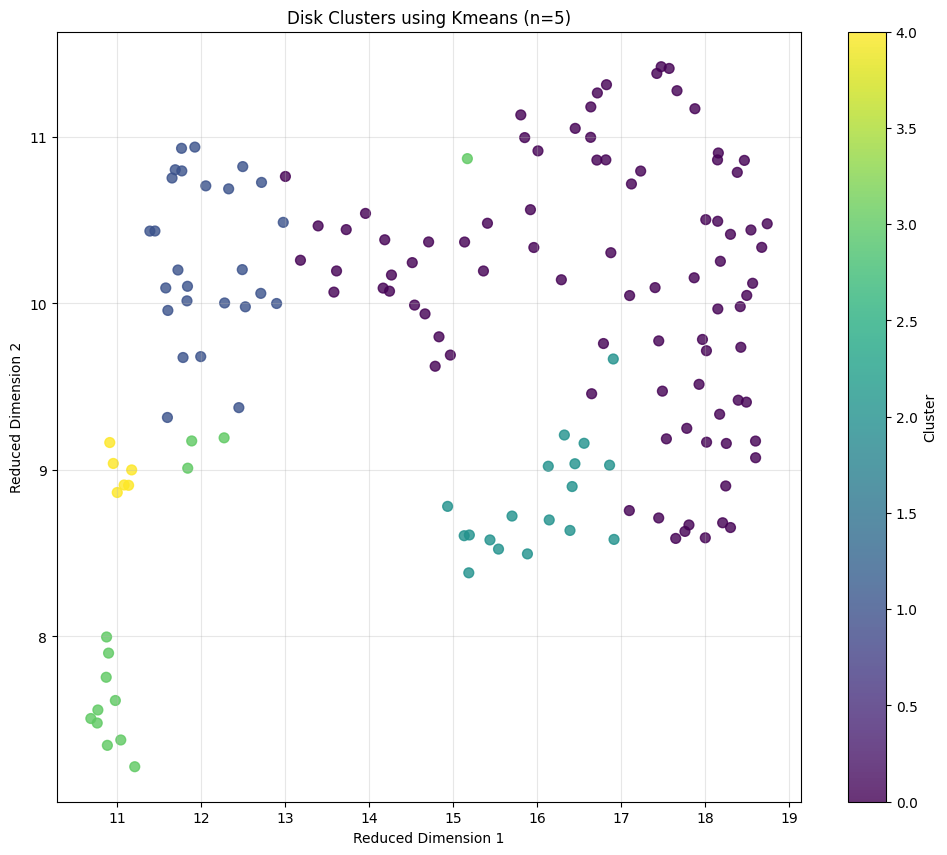

In [15]:
custom_cluster_analyser.visualize_clusters()

## Cluster Samples

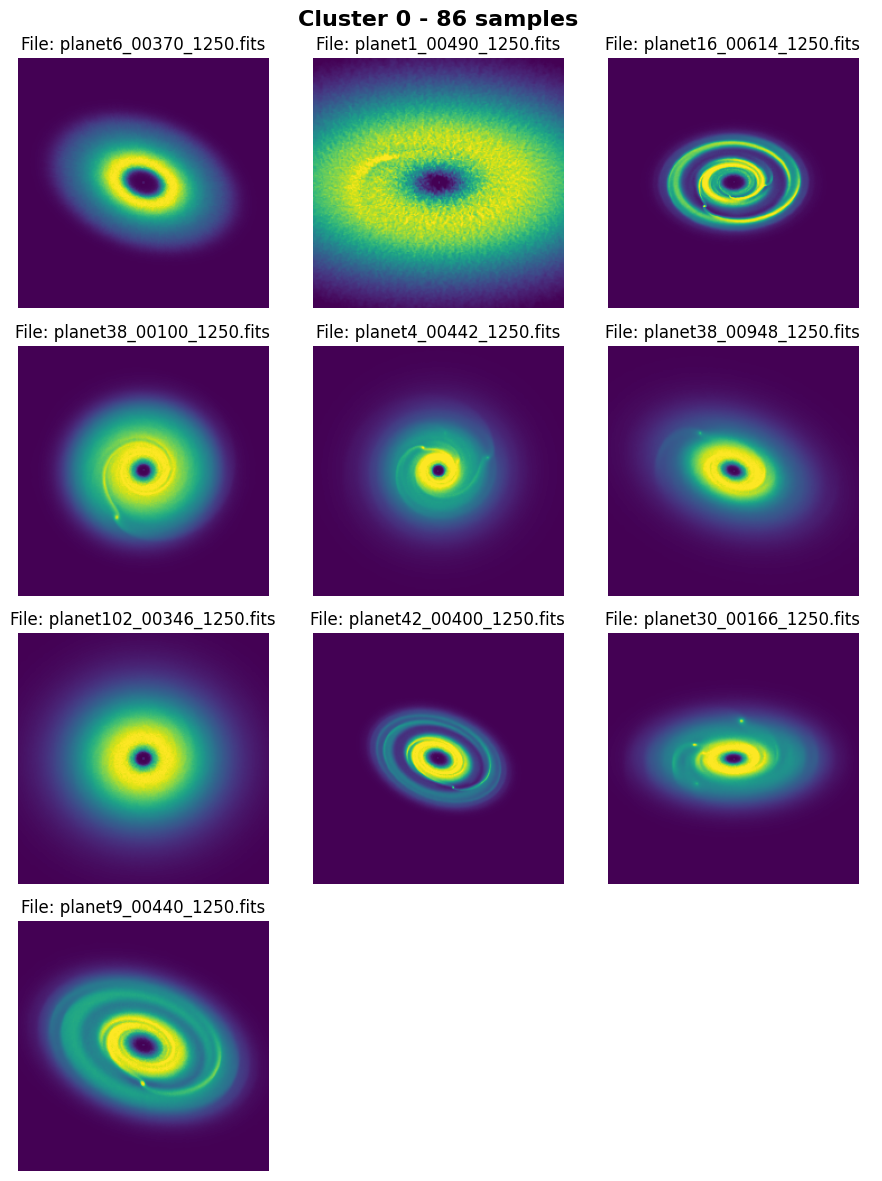

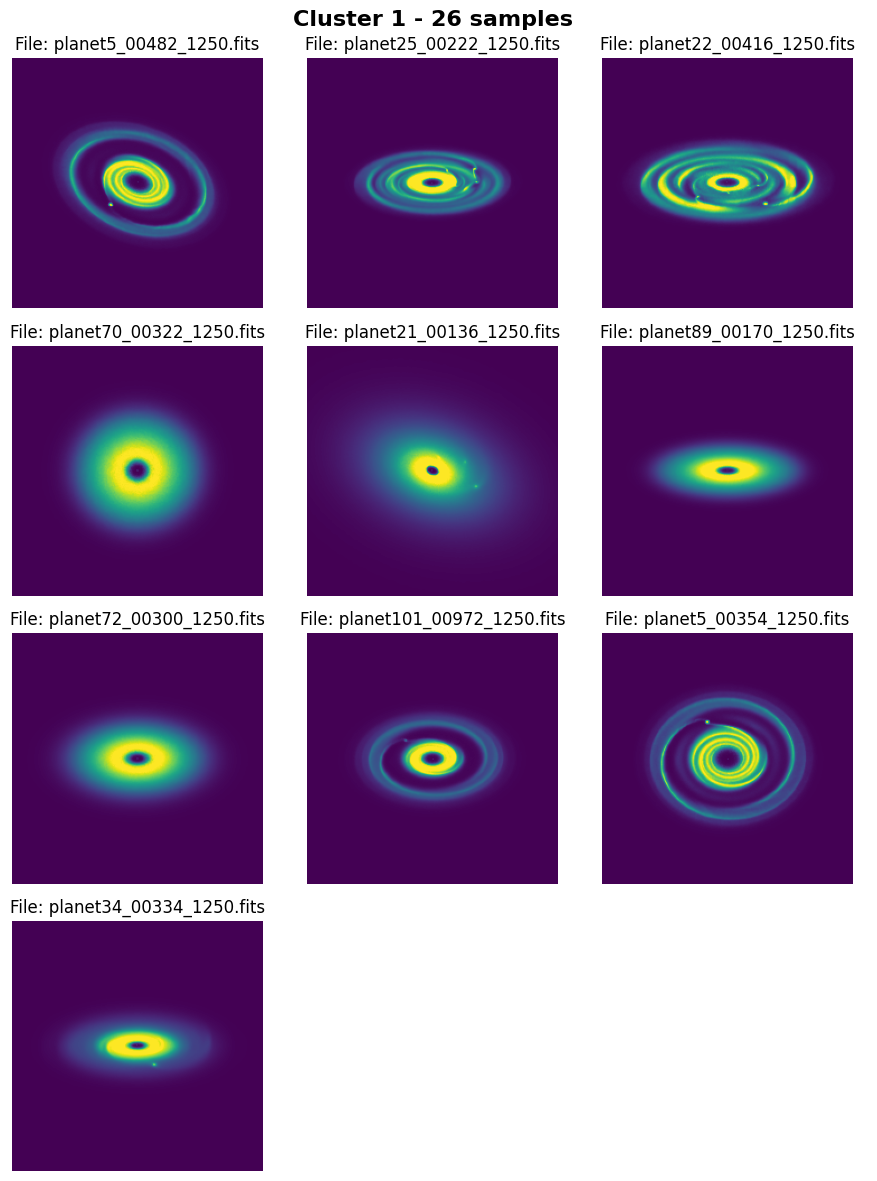

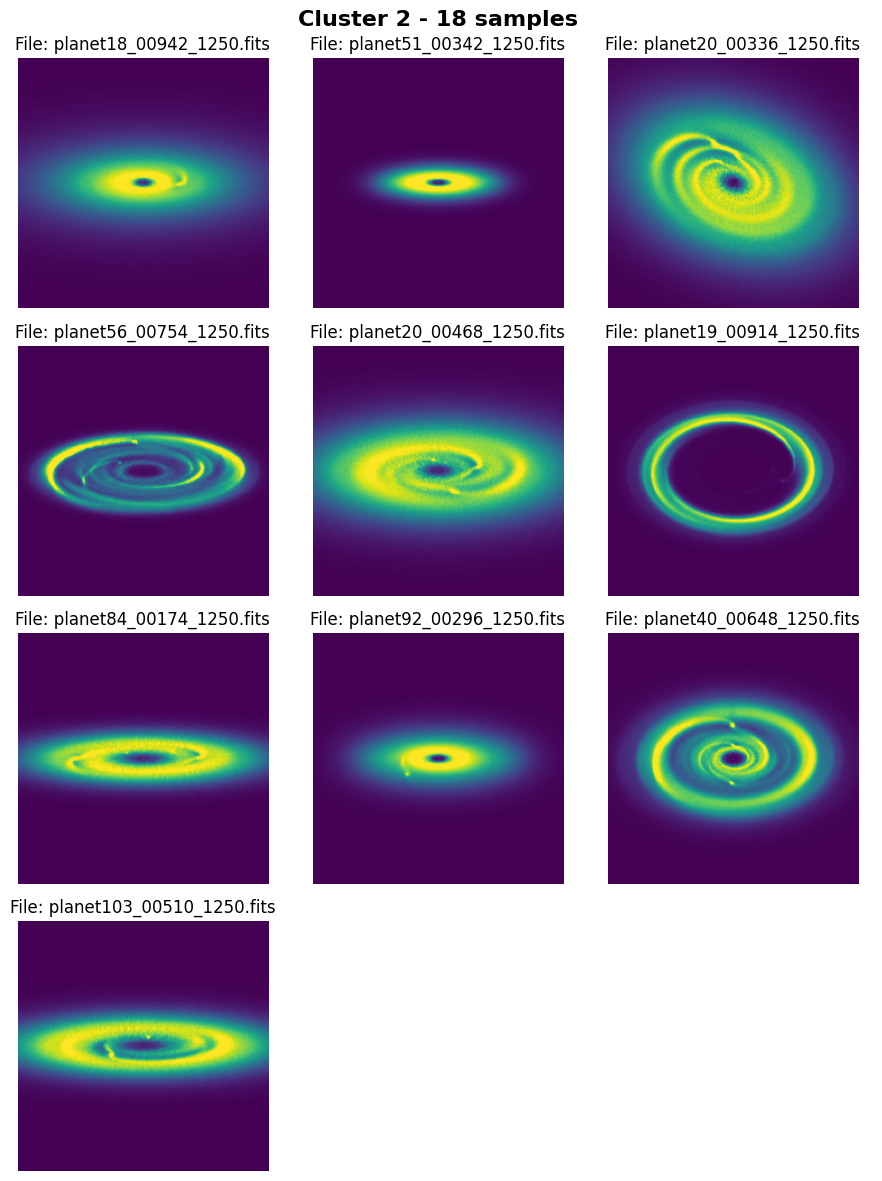

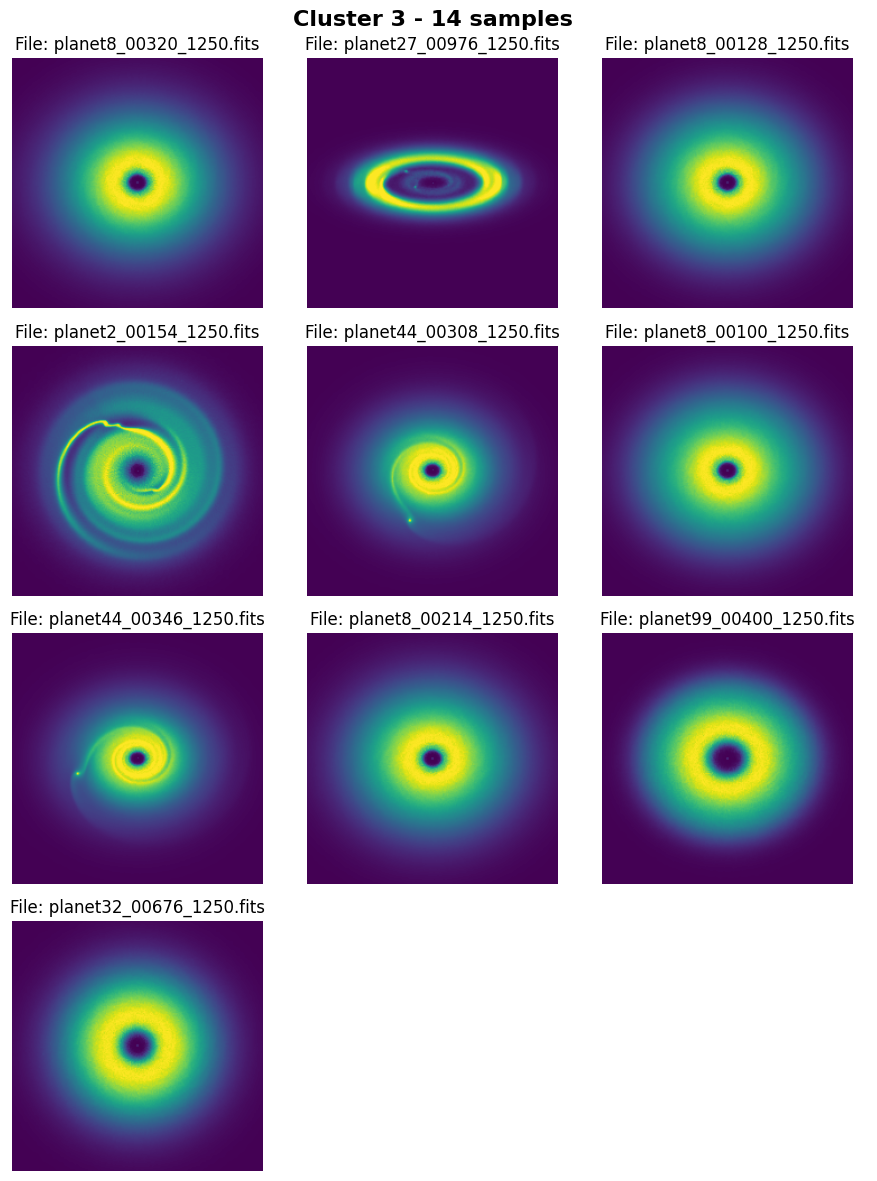

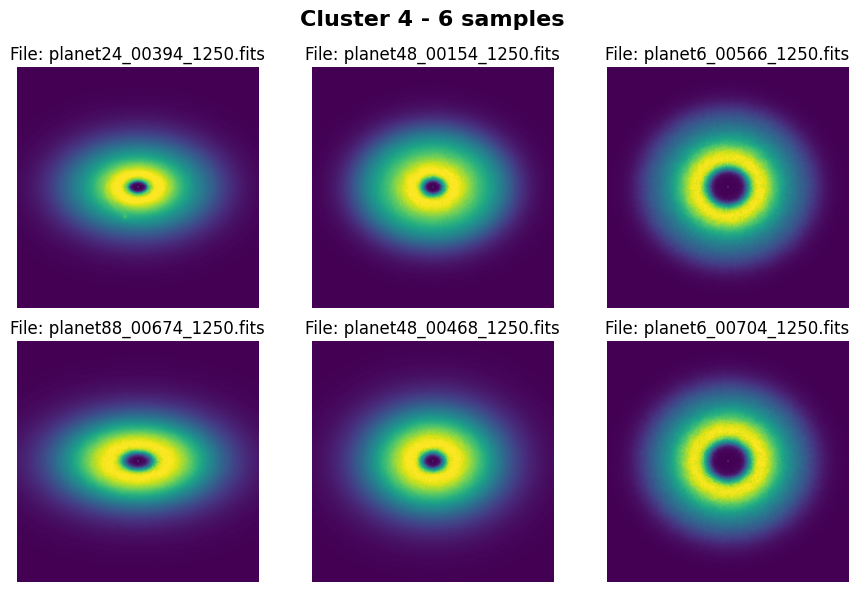

In [16]:
custom_cluster_analyser.plot_cluster()

# Final Comments
* Custom feature extraction provides better clustering
* I will leverage this technique in Image-based task for autoencoder training
* Custom model is more interpretable and is able to differentiate between various cluster of the continuum data